In [36]:
import os
import librosa, librosa.display
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
import IPython.display as ipd
import numpy as np
import shutil
#import ftransc

In [37]:

train_directory = './all_data/donate/poly/mel_spectrogram/train'
test_directory = './all_data/donate/poly/mel_spectrogram/test'
#train_directory = './data/poly/mel_spectrogram/train'
#test_directory = './data/poly/mel_spectrogram/test'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='int', image_size=(256, 256), seed=321,
    validation_split=None, subset=None)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory, labels='inferred', label_mode='int', image_size=(256, 256),
    validation_split=None, subset=None)

class_names = train_ds.class_names
print(class_names)

Found 36 files belonging to 4 classes.
Found 20 files belonging to 4 classes.
['burping', 'discomfort', 'poop', 'tired']


In [38]:
## create model

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.callbacks import ModelCheckpoint

In [40]:
def dummy(data):
    new_data =[]
    for i in data:
        lab_data =[0,0,0,0]
        lab_data[i] = 1
        new_data.append(lab_data)
    return new_data

In [41]:
x_train=[]
y_train=[]
for images, labels in train_ds.unbatch().take(-1):
    x_train.append(images.numpy())
    y_train.append(labels.numpy())

In [42]:
x_test=[]
y_test=[]
for images, labels in test_ds.unbatch().take(-1):
    x_test.append(images.numpy())
    y_test.append(labels.numpy())

In [43]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [44]:
class_count = np.array([np.count_nonzero(y_train ==0),np.count_nonzero(y_train ==1),np.count_nonzero(y_train ==2),np.count_nonzero(y_train ==3)])

In [45]:
y_train = dummy(y_train)
y_test = dummy(y_test)

In [46]:
class_count

array([ 3, 12,  9, 12])

In [47]:
class_count.sum()

36

In [48]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [49]:
img_height = 256
img_width = 256

In [50]:
num_classes = 4

def create_weight(n_sample,n_class,n_class_sample):
    weight = n_sample/(n_class*n_class_sample)
    return weight 

In [51]:
class_weights = {0:0, 1:0,2:0,3:0}

for i in range(num_classes):
    class_weights[i]=create_weight(class_count.sum(),num_classes,class_count[i])

In [52]:
class_weights

{0: 3.0, 1: 0.75, 2: 1.0, 3: 0.75}

In [53]:
base_model = tf.keras.applications.ResNet50V2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False,
) 

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = tf.keras.Input(shape=(img_height, img_width, 3))

scale_layer = tf.keras.layers.Rescaling(scale=1./255)
x = scale_layer(inputs)

x = tf.cast(x,tf.float32)

x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

#x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = tf.keras.layers.Dense(4,activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 tf.cast_1 (TFOpLambda)      (None, 256, 256, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                           

In [54]:
''' #model = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
            tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
            tf.keras.layers.MaxPooling2D((2,2)),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),            
            tf.keras.layers.MaxPooling2D((2,2)),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
            tf.keras.layers.MaxPooling2D((2,2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
model.summary() '''

" #model = tf.keras.Sequential([\n            tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),\n            tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),\n            tf.keras.layers.MaxPooling2D((2,2)),\n            tf.keras.layers.Dropout(0.2),\n            tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),            \n            tf.keras.layers.MaxPooling2D((2,2)),\n            tf.keras.layers.Dropout(0.2),\n            tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),\n            tf.keras.layers.MaxPooling2D((2,2)),\n            tf.keras.layers.Flatten(),\n            tf.keras.layers.Dense(64, activation='relu'),\n            tf.keras.layers.Dense(1, activation='sigmoid')\n        ])\nmodel.summary() "

In [55]:
#resnet 
#inception v3

In [56]:

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()# modify weight in Adam
metrics = ['accuracy']
model.compile (optimizer = optimizer,loss =  loss_fn,metrics = metrics)

In [57]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [58]:
# Set the epocks
# ทำ stop + validation
epochs = 100
history = model.fit(x_train, y_train, epochs=epochs,validation_split=0.3,callbacks=callback,class_weight = class_weights)

#history = model.fit(x_train, y_train, epochs=epochs,validation_split=0.3)

Epoch 1/100


c:\Users\acer\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1/1 [==============================] - 5s 5s/step - loss: 1.4704 - accuracy: 0.3600 - val_loss: 1.7124 - val_accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 2s 2s/step - loss: 1.4455 - accuracy: 0.2400 - val_loss: 1.9485 - val_accuracy: 0.0909
Epoch 3/100
1/1 [==============================] - 2s 2s/step - loss: 1.3123 - accuracy: 0.4000 - val_loss: 2.1228 - val_accuracy: 0.0909
Epoch 4/100
1/1 [==============================] - 2s 2s/step - loss: 1.4003 - accuracy: 0.4000 - val_loss: 2.2205 - val_accuracy: 0.0909
Epoch 5/100
1/1 [==============================] - 2s 2s/step - loss: 1.2411 - accuracy: 0.5200 - val_loss: 2.2596 - val_accuracy: 0.0909
Epoch 6/100
1/1 [==============================] - 2s 2s/step - loss: 1.1011 - accuracy: 0.5200 - val_loss: 2.2522 - val_accuracy: 0.0909


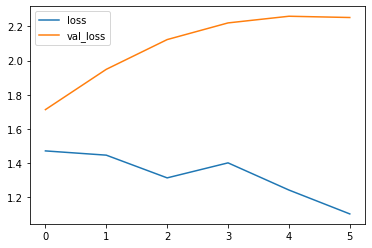

In [59]:
plt.plot(history.history['loss'],label = 'loss')
plt.plot(history.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()

In [60]:
base_model.trainable = True
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

epochs = 50
history = model.fit(x_train, y_train, epochs=epochs,validation_split=0.3,callbacks=callback,class_weight = class_weights)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 tf.cast_1 (TFOpLambda)      (None, 256, 256, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                           

c:\Users\acer\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1/1 [==============================] - 11s 11s/step - loss: 1.2045 - binary_accuracy: 0.7700 - val_loss: 1.9513 - val_binary_accuracy: 0.6364
Epoch 2/50
1/1 [==============================] - 6s 6s/step - loss: 0.9444 - binary_accuracy: 0.8100 - val_loss: 1.9037 - val_binary_accuracy: 0.6591
Epoch 3/50
1/1 [==============================] - 6s 6s/step - loss: 0.7444 - binary_accuracy: 0.8900 - val_loss: 1.9088 - val_binary_accuracy: 0.6818
Epoch 4/50
1/1 [==============================] - 5s 5s/step - loss: 0.6326 - binary_accuracy: 0.8800 - val_loss: 1.9439 - val_binary_accuracy: 0.6591
Epoch 5/50
1/1 [==============================] - 5s 5s/step - loss: 0.4184 - binary_accuracy: 0.9700 - val_loss: 1.9778 - val_binary_accuracy: 0.5909
Epoch 6/50
1/1 [==============================] - 5s 5s/step - loss: 0.3994 - binary_accuracy: 0.9500 - val_loss: 1.9399 - val_binary_accuracy: 0.6364
Epoch 7/50
1/1 [==============================] - 5s 5s/step - loss: 0.2426 - binary_accuracy: 0.9900 -

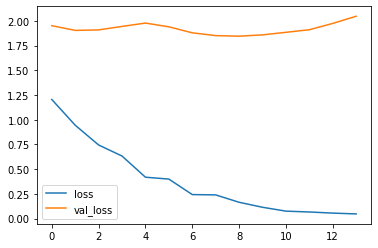

In [61]:
plt.plot(history.history['loss'],label = 'loss')
plt.plot(history.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()

In [62]:
pred = model.predict(x_test)

y_pred = np.argmax(pred, axis=1)
actual = x_test

In [63]:
y_pred

array([2, 2, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 2, 3, 2, 3],
      dtype=int64)

In [64]:
y_test

array([[0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])

In [65]:
y_test = np.argmax(y_test, axis=1)

<function matplotlib.pyplot.show(*args, **kw)>

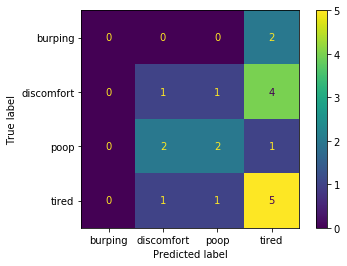

In [66]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot()
plt.show

In [67]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,target_names=class_names))

              precision    recall  f1-score   support

     burping       0.00      0.00      0.00         2
  discomfort       0.25      0.17      0.20         6
        poop       0.50      0.40      0.44         5
       tired       0.42      0.71      0.53         7

    accuracy                           0.40        20
   macro avg       0.29      0.32      0.29        20
weighted avg       0.35      0.40      0.36        20



c:\Users\acer\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\acer\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\acer\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
